In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from pycaret.regression import setup as setup_reg, compare_models as compare_models_reg, tune_model as tune_model_reg, pull as pull_reg
from pycaret.classification import setup as setup_clf, compare_models as compare_models_clf, tune_model as tune_model_clf, pull as pull_clf

sns.set_theme()
np.random.seed(50)

In [2]:
df = pd.read_csv("flights.csv")
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("Visão geral do dataset de voos:")
display(df.head())
df.info()


Visão geral do dataset de voos:


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [4]:
display(df.describe())
print("Valores ausentes por coluna:")
display(df.isna().sum())

,YEAR,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,...,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
count,5819079.0,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.819079e+06,5.732926e+06,5.732926e+06,5.730032e+06,5.730032e+06,...,5.819079e+06,5.726566e+06,5.714008e+06,5.819079e+06,5.819079e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06,1.063439e+06
mean,2015.0,6.524085e+00,1.570459e+01,3.926941e+00,2.173093e+03,1.329602e+03,1.335204e+03,9.370158e+00,1.607166e+01,1.357171e+03,...,1.493808e+03,1.476491e+03,4.407057e+00,2.609863e-03,1.544643e-02,1.348057e+01,7.615387e-02,1.896955e+01,2.347284e+01,2.915290e+00
std,0.0,3.405137e+00,8.783425e+00,1.988845e+00,1.757064e+03,4.837518e+02,4.964233e+02,3.708094e+01,8.895574e+00,4.980094e+02,...,5.071647e+02,5.263197e+02,3.927130e+01,5.102012e-02,1.233201e-01,2.800368e+01,2.143460e+00,4.816164e+01,4.319702e+01,2.043334e+01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,-8.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,7.300000e+02,9.170000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,...,1.110000e+03,1.059000e+03,-1.300000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.690000e+03,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,...,1.520000e+03,1.512000e+03,-5.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,3.000000e+00,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,3.230000e+03,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,...,1.918000e+03,1.917000e+03,8.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,0.000000e+00,1.900000e+01,2.900000e+01,0.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,9.855000e+03,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,...,2.400000e+03,2.400000e+03,1.971000e+03,1.000000e+00,1.000000e+00,1.134000e+03,5.730000e+02,1.971000e+03,1.331000e+03,1.211000e+03


Valores ausentes por coluna:


YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

In [5]:
dg = pd.read_csv("airlines.csv")
dg.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


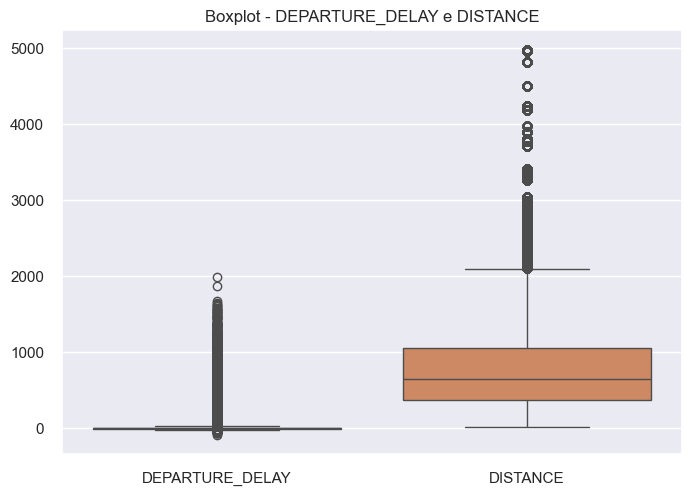

In [6]:
# Boxplot de atraso de partida e distância
plt.figure()
sns.boxplot(data=df[['DEPARTURE_DELAY', 'DISTANCE']])
plt.title("Boxplot - DEPARTURE_DELAY e DISTANCE")
plt.show()

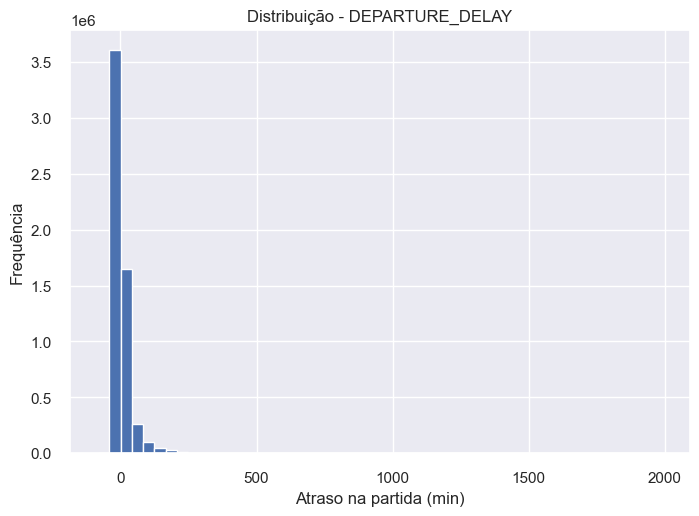

In [7]:
plt.figure()
df['DEPARTURE_DELAY'].hist(bins=50)
plt.title("Distribuição - DEPARTURE_DELAY")
plt.xlabel("Atraso na partida (min)")
plt.ylabel("Frequência")
plt.show()

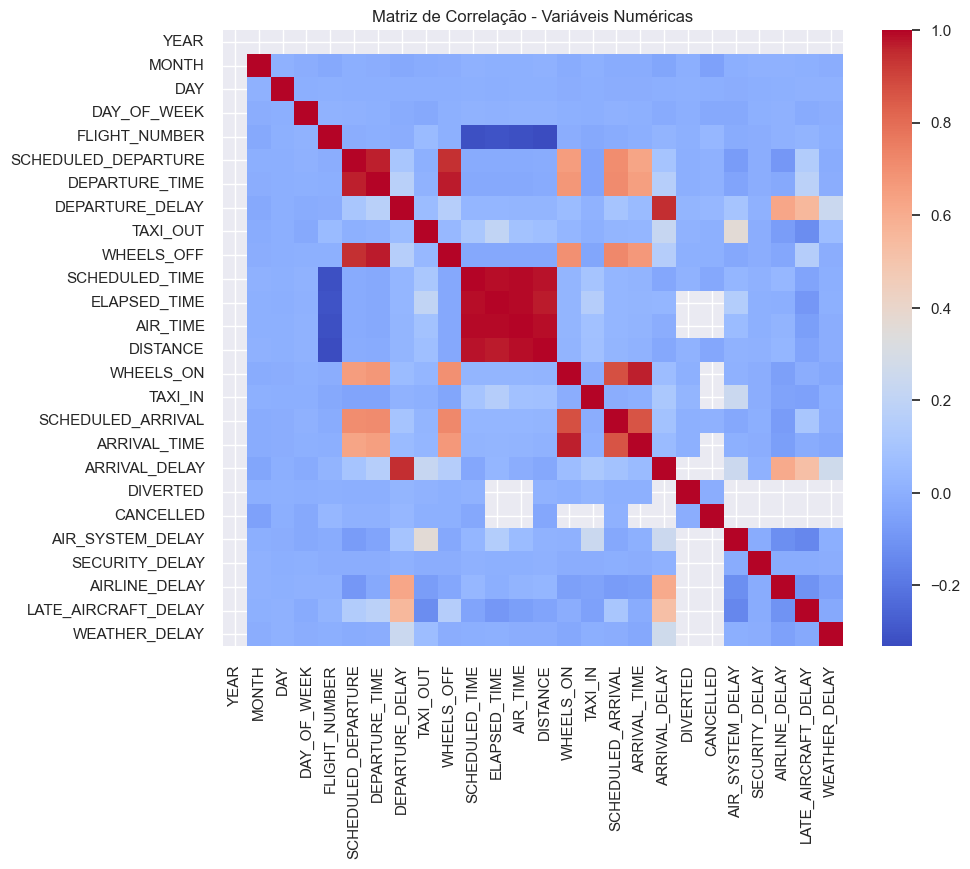

In [8]:
# Matriz de correlação numérica
num_df = df.select_dtypes(include=['number'])
plt.figure(figsize=(10, 8))
sns.heatmap(num_df.corr(), annot=False, cmap='coolwarm')
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()

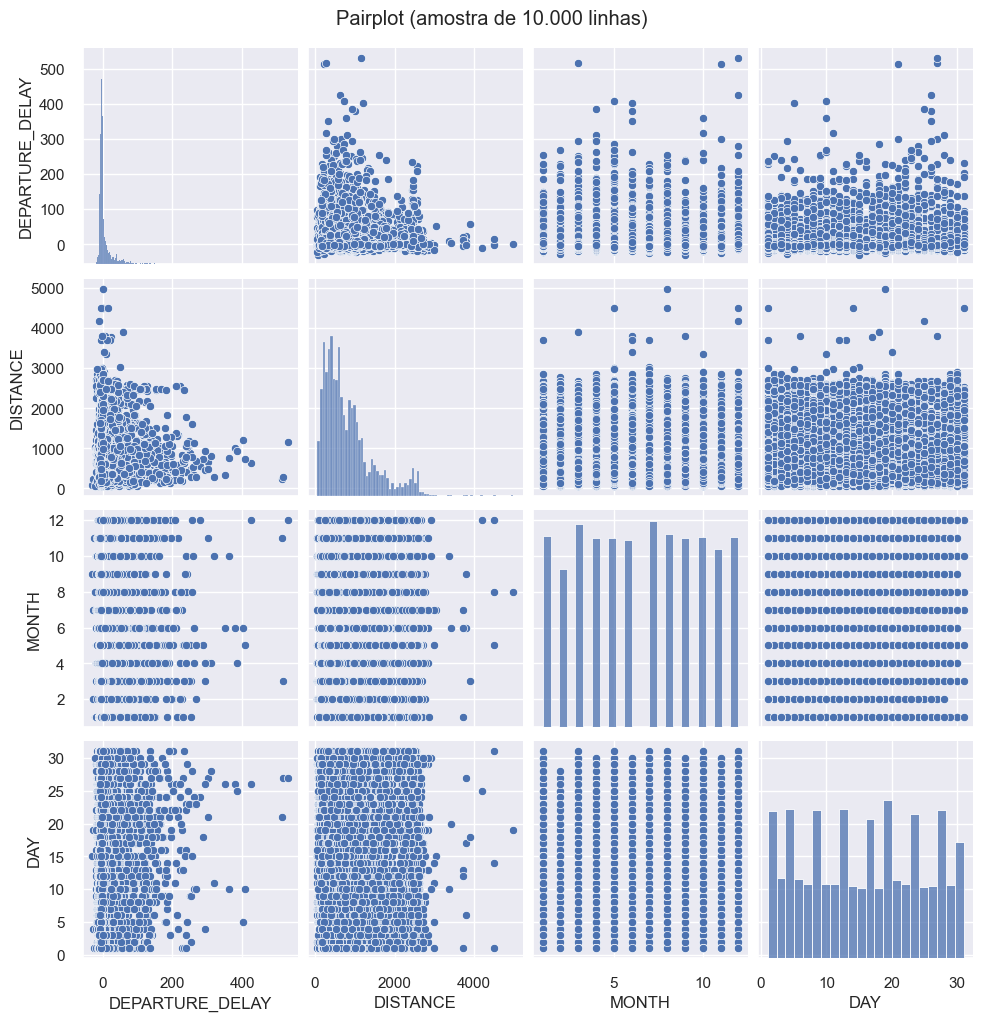

In [9]:
# Pairplot em amostra menor
df_sample_pair = df[['DEPARTURE_DELAY', 'DISTANCE', 'MONTH', 'DAY']].dropna().sample(10_000, random_state=42)
sns.pairplot(df_sample_pair)
plt.suptitle("Pairplot (amostra de 10.000 linhas)", y=1.02)
plt.show()


In [10]:
# Amostra de 100.000 linhas para trabalhar
df_sample = df.sample(100_000, random_state=42).copy()
print("Shape da amostra:", df_sample.shape)

Shape da amostra: (100000, 31)


In [11]:
# Remover linhas sem ARRIVAL_DELAY (não conseguimos avaliar atraso de chegada)
df_clean = df_sample.dropna(subset=['ARRIVAL_DELAY']).copy()
print("Shape após remover NA em ARRIVAL_DELAY:", df_clean.shape)

Shape após remover NA em ARRIVAL_DELAY: (98195, 31)


In [12]:
# Variável-alvo binária: voo atrasado (> 15 min)
df_clean['LATE'] = (df_clean['ARRIVAL_DELAY'] > 15).astype(int)
display(df_clean[['ARRIVAL_DELAY', 'LATE']].head())

,ARRIVAL_DELAY,LATE
1508570,-13.0,0
363270,-12.0,0
3003945,-8.0,0
2291425,152.0,1
2973084,-2.0,0


In [13]:
# Definindo colunas numéricas para modelagem
num_cols = ['DEPARTURE_DELAY', 'DISTANCE', 'MONTH', 'DAY']

In [14]:
df_model = df_clean[num_cols + ['ARRIVAL_DELAY', 'LATE']].copy()
display(df_model.describe().T)

,count,mean,std,min,25%,50%,75%,max
DEPARTURE_DELAY,98195.0,9.311136,36.886612,-36.0,-5.0,-2.0,7.0,1576.0
DISTANCE,98195.0,825.277998,608.412431,31.0,374.0,649.0,1067.0,4983.0
MONTH,98195.0,6.540302,3.399689,1.0,4.0,7.0,9.0,12.0
DAY,98195.0,15.719018,8.774621,1.0,8.0,16.0,23.0,31.0
ARRIVAL_DELAY,98195.0,4.424237,39.272194,-70.0,-13.0,-5.0,8.0,1557.0
LATE,98195.0,0.180172,0.384333,0.0,0.0,0.0,0.0,1.0


In [15]:
# Split para regressão
X = df_model[num_cols]
y = df_model['ARRIVAL_DELAY']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Shapes (Regressão):", X_train.shape, X_test.shape)

Shapes (Regressão): (78556, 4) (19639, 4)


In [17]:
y_pred_baseline = np.full(shape=y_test.shape, fill_value=y_train.mean())

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = mean_squared_error(y_test, y_pred_baseline, squared=False)
r2_base = r2_score(y_test, y_pred_baseline)

print("\nBaseline (predizer média de ARRIVAL_DELAY):")
print(f"MAE  = {mae_base:.2f}")
print(f"RMSE = {rmse_base:.2f}")
print(f"R²   = {r2_base:.4f}")


Baseline (predizer média de ARRIVAL_DELAY):
MAE  = 21.37
RMSE = 40.01
R²   = -0.0001


In [18]:
df_reg_sm = df_model[['ARRIVAL_DELAY', 'DEPARTURE_DELAY']].copy()
model_sm = smf.ols("ARRIVAL_DELAY ~ DEPARTURE_DELAY", data=df_reg_sm).fit()
print("\nResumo OLS (ARRIVAL_DELAY ~ DEPARTURE_DELAY):")
display(model_sm.summary())


Resumo OLS (ARRIVAL_DELAY ~ DEPARTURE_DELAY):


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          ARRIVAL_DELAY   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 8.069e+05
Date:                Thu, 04 Dec 2025   Prob (F-statistic):               0.00
Time:                        02:08:06   Log-Likelihood:            -3.9071e+05
No. Observations:               98195   AIC:                         7.814e+05
Df Residuals:                   98193   BIC:                         7.814e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -4.9359      0.043   -115.937      0.000      -5.019      -4.852
DEPARTURE_DELAY     1.0053      0.001    898.287      0.000       1.003       1.007
==============================================================================
Omnibus:                    36761.824   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           404337.091
Skew:                           1.488   Prob(JB):                         0.00
Kurtosis:                      12.485   Cond. No.                         39.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
print("\nCoeficientes OLS:")
print(model_sm.params)
print("\nP-valores:")
print(model_sm.pvalues)


Coeficientes OLS:
Intercept         -4.935914
DEPARTURE_DELAY    1.005264
dtype: float64

P-valores:
Intercept          0.0
DEPARTURE_DELAY    0.0
dtype: float64


In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
r2_lr = r2_score(y_test, y_pred_lr)

In [21]:
print("\nRegressão Linear Múltipla:")
print(f"MAE  = {mae_lr:.2f}")
print(f"RMSE = {rmse_lr:.2f}")
print(f"R²   = {r2_lr:.4f}")


Regressão Linear Múltipla:
MAE  = 9.07
RMSE = 13.04
R²   = 0.8937


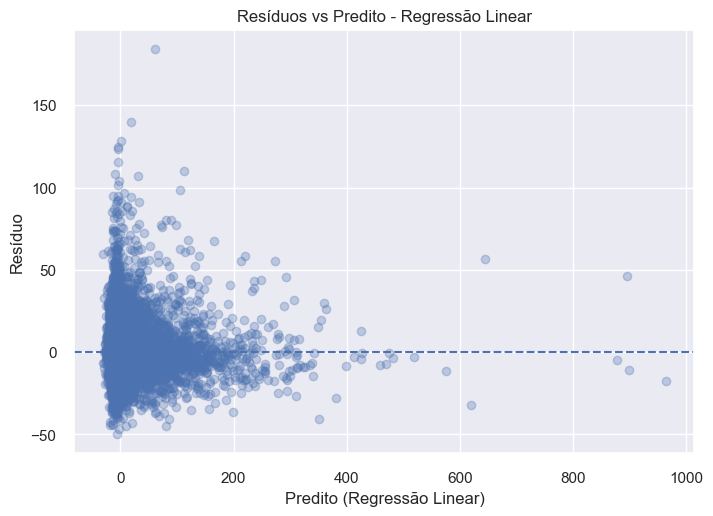

In [22]:
residuos_lr = y_test - y_pred_lr

plt.figure()
plt.scatter(y_pred_lr, residuos_lr, alpha=0.3)
plt.axhline(0, linestyle='--')
plt.xlabel("Predito (Regressão Linear)")
plt.ylabel("Resíduo")
plt.title("Resíduos vs Predito - Regressão Linear")
plt.show()

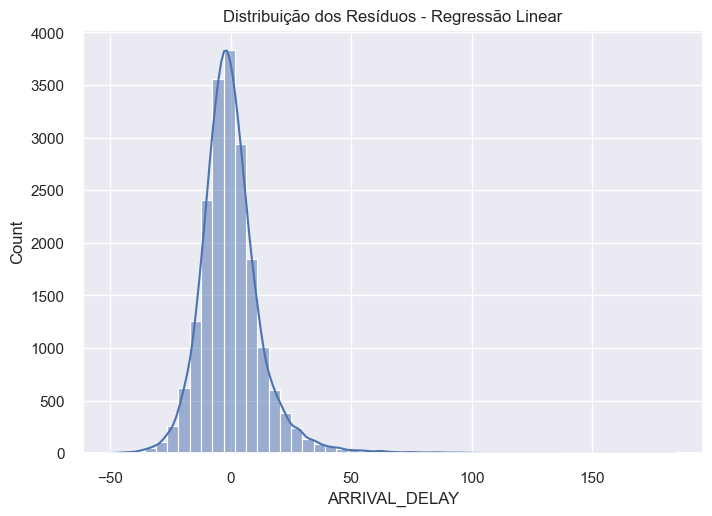

In [23]:
plt.figure()
sns.histplot(residuos_lr, bins=50, kde=True)
plt.title("Distribuição dos Resíduos - Regressão Linear")
plt.show()

In [24]:
basePoli = X_train[['DEPARTURE_DELAY', 'DISTANCE']]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly.fit_transform(basePoli)

lr_poly = LinearRegression()
lr_poly.fit(X_poly_train, y_train)

X_poly_test = poly.transform(X_test[['DEPARTURE_DELAY', 'DISTANCE']])
y_pred_poly = lr_poly.predict(X_poly_test)

mae_poly = mean_absolute_error(y_test, y_pred_poly)
rmse_poly = mean_squared_error(y_test, y_pred_poly, squared=False)
r2_poly = r2_score(y_test, y_pred_poly)

print("\nRegressão Polinomial (grau 2):")
print(f"MAE  = {mae_poly:.2f}")
print(f"RMSE = {rmse_poly:.2f}")
print(f"R²   = {r2_poly:.4f}")


Regressão Polinomial (grau 2):
MAE  = 9.07
RMSE = 13.03
R²   = 0.8938


In [25]:
basePoli = X_train[['DEPARTURE_DELAY', 'DISTANCE']]

poly = PolynomialFeatures(degree=2, include_bias=False)
xpolinom = poly.fit_transform(basePoli)

lrpolimon = LinearRegression()
lrpolimon.fit(xpolinom, y_train)
testeX = poly.transform(X_test[['DEPARTURE_DELAY', 'DISTANCE']])
predicaoY = lrpolimon.predict(testeX)

m = mean_absolute_error(y_test, predicaoY)
polinomrse = mean_squared_error(y_test, predicaoY, squared=False)
R2 = r2_score(y_test, predicaoY)

print("Regressão Polinomial:")
print(f"MAE  = {m:.2f}")
print(f"RMSE = {polinomrse:.2f}")
print(f"R**2   = {R2:.4f}")


Regressão Polinomial:
MAE  = 9.07
RMSE = 13.03
R**2   = 0.8938


In [26]:
# Comparação em tabela
reg_results = pd.DataFrame({
    "Modelo": ["Baseline (média)", "Linear Múltipla", "Polinomial (grau 2)"],
    "MAE": [mae_base, mae_lr, mae_poly],
    "RMSE": [rmse_base, rmse_lr, rmse_poly],
    "R2": [r2_base, r2_lr, r2_poly]
})
print("\nComparação de modelos de regressão:")
display(reg_results)



Comparação de modelos de regressão:


,Modelo,MAE,RMSE,R2
0,Baseline (média),21.374173,40.005176,-0.000056
1,Linear Múltipla,9.070503,13.040505,0.893737
2,Polinomial (grau 2),9.072379,13.033932,0.893844


In [27]:
X_vif = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = ["const"] + num_cols
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]
print("\nVIF - Fator de Inflação da Variância:")
display(vif_data)


VIF - Fator de Inflação da Variância:


,feature,VIF
0,const,9.713964
1,DEPARTURE_DELAY,1.000776
2,DISTANCE,1.000523
3,MONTH,1.000461
4,DAY,1.000049


In [28]:
X_clf = df_model[num_cols]
y_clf = df_model['LATE']

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

print("\nShapes (Classificação):", Xc_train.shape, Xc_test.shape)
print("Proporção de atrasos (treino):", yc_train.mean())
print("Proporção de atrasos (teste) :", yc_test.mean())


Shapes (Classificação): (78556, 4) (19639, 4)
Proporção de atrasos (treino): 0.18017719843169205
Proporção de atrasos (teste) : 0.1801517388869087


In [29]:
majority_class = yc_train.mode()[0]
y_pred_majority = np.full_like(yc_test, fill_value=majority_class)

print("\nBaseline (classe majoritária):")
print("Accuracy :", accuracy_score(yc_test, y_pred_majority))
print("Precision:", precision_score(yc_test, y_pred_majority, zero_division=0))
print("Recall   :", recall_score(yc_test, y_pred_majority, zero_division=0))
print("F1       :", f1_score(yc_test, y_pred_majority, zero_division=0))


Baseline (classe majoritária):
Accuracy : 0.8198482611130913
Precision: 0.0
Recall   : 0.0
F1       : 0.0


In [30]:
nb = GaussianNB()
nb.fit(Xc_train, yc_train)

pred_nb = nb.predict(Xc_test)
proba_nb = nb.predict_proba(Xc_test)[:, 1]


In [31]:
print("\nNaive Bayes:")
print("Accuracy :", accuracy_score(yc_test, pred_nb))
print("Precision:", precision_score(yc_test, pred_nb))
print("Recall   :", recall_score(yc_test, pred_nb))
print("F1       :", f1_score(yc_test, pred_nb))
print("AUC ROC  :", roc_auc_score(yc_test, proba_nb))

cm_nb = confusion_matrix(yc_test, pred_nb)
print("Matriz de confusão (NB):")
print(cm_nb)
print("\nRelatório de classificação (NB):")
print(classification_report(yc_test, pred_nb))


Naive Bayes:
Accuracy : 0.9308518763684506
Precision: 0.8684922244759973
Recall   : 0.7261164499717354
F1       : 0.790948275862069
AUC ROC  : 0.9052275087001153
Matriz de confusão (NB):
[[15712   389]
 [  969  2569]]

Relatório de classificação (NB):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16101
           1       0.87      0.73      0.79      3538

    accuracy                           0.93     19639
   macro avg       0.91      0.85      0.87     19639
weighted avg       0.93      0.93      0.93     19639



In [32]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(Xc_train, yc_train)

pred_log = log_reg.predict(Xc_test)
proba_log = log_reg.predict_proba(Xc_test)[:, 1]

print("\nRegressão Logística:")
print("Accuracy :", accuracy_score(yc_test, pred_log))
print("Precision:", precision_score(yc_test, pred_log))
print("Recall   :", recall_score(yc_test, pred_log))
print("F1       :", f1_score(yc_test, pred_log))
print("AUC ROC  :", roc_auc_score(yc_test, proba_log))


Regressão Logística:
Accuracy : 0.9317684199806507
Precision: 0.8941893830703013
Recall   : 0.7046353872244205
F1       : 0.7881757824849827
AUC ROC  : 0.9234236264866892


In [33]:
cm_log = confusion_matrix(yc_test, pred_log)
print("Matriz de confusão (LogReg):")
print(cm_log)
print("\nRelatório de classificação (LogReg):")
print(classification_report(yc_test, pred_log))


Matriz de confusão (LogReg):
[[15806   295]
 [ 1045  2493]]

Relatório de classificação (LogReg):
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     16101
           1       0.89      0.70      0.79      3538

    accuracy                           0.93     19639
   macro avg       0.92      0.84      0.87     19639
weighted avg       0.93      0.93      0.93     19639



In [34]:
scores_reg = cross_val_score(LinearRegression(), X, y, cv=5, scoring='r2')
print("\nCV R² (Regressão Linear, 5-fold):", scores_reg)
print("Média R²:", scores_reg.mean())



CV R² (Regressão Linear, 5-fold): [0.88128669 0.89075079 0.89265568 0.89908125 0.90393998]
Média R²: 0.8935428785512072


In [35]:
scores_clf = cross_val_score(LogisticRegression(max_iter=1000), X_clf, y_clf, cv=5, scoring='f1')
print("\nCV F1 (Regressão Logística, 5-fold):", scores_clf)
print("Média F1:", scores_clf.mean())


CV F1 (Regressão Logística, 5-fold): [0.79328733 0.80031447 0.79450344 0.79734639 0.79207921]
Média F1: 0.7955061653872187


In [41]:
param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

log_reg_grid = LogisticRegression(max_iter=1000)

grid = GridSearchCV(
    estimator=log_reg_grid,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(Xc_train, yc_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [42]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.7972585910038228


In [43]:
print("\nGridSearchCV - Regressão Logística:")
print("Melhores parâmetros:", grid.best_params_)
print("Melhor F1 (CV):", grid.best_score_)

best_log_model = grid.best_estimator_
pred_best = best_log_model.predict(Xc_test)
print("F1 no conjunto de teste (modelo tunado):", f1_score(yc_test, pred_best))


GridSearchCV - Regressão Logística:
Melhores parâmetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Melhor F1 (CV): 0.7972585910038228
F1 no conjunto de teste (modelo tunado): 0.7884433217556047
